In [ ]:
import tensorflow as tf

AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:

# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm


In [ ]:


DATA_DIR = Path("../input/stanford-covid-vaccine/")
BPPS_DIR = DATA_DIR / "bpps"

train = pd.read_json('../input/stanford-covid-vaccine/train.json',lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
submission = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')

public_test_df = test[test['seq_length'] == 107]
private_test_df = test[test['seq_length'] == 130]
seq_feats = ['sequence', 'structure', 'predicted_loop_type', ]
# add bppm
def get_bppm(id_):
    return np.load(BPPS_DIR / f"{id_}.npy")

def get_structure(structure: str):
    pm = np.zeros((len(structure), len(structure)))
    start_token_indices = []
    for i, token in enumerate(structure):
        if token == "(":
            start_token_indices.append(i)
        elif token == ")":
            j = start_token_indices.pop()
            pm[i, j] = 1.0
            pm[j, i] = 1.0
    return pm

def plot_structures(bppm: np.ndarray, pm: np.ndarray):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(bppm)
    axes[0].set_title("BPPM")
    axes[1].imshow(pm)
    axes[1].set_title("structure")
    plt.show()
def get_bppm_feats(df, base_len=68):
    bppm = np.zeros((df['id'].nunique(), base_len))
    for i, id_ in tqdm(enumerate(df['id'].unique())):
        img = get_bppm(id_)
        maxv = np.max(img, axis=0)
        if len(maxv) >= base_len:
            bppm[i, :base_len] = maxv[:base_len]
        else:
            bppm[i, :len(maxv)] = maxv
    return bppm

bppm_train = get_bppm_feats(train)
public_bppm_test = get_bppm_feats(public_test_df, public_test_df['seq_length'].max())
private_bppm_test = get_bppm_feats(private_test_df, private_test_df['seq_length'].max())


In [ ]:
bppm_train.shape
public_bppm_test.shape
private_bppm_test.shape

In [ ]:

# # plot images from the training dataset
for i in range(10):
    # define subplot
    fig, axes = plt.subplots(1, 2)
    # turn off axis
    axes[0].imshow(bppm)
    axes[0].set_title("BPPM")    # plot raw pixel data
    sample = train.loc[i]
    bppm = get_bppm(sample.id)
    plt.imshow(bppm) 
plt.show()

Conditional GAN for Fashion-MNIST
In this section, we will develop a conditional GAN for the Fashion-MNIST dataset by updating the unconditional GAN developed in the previous section.

The best way to design models in Keras to have multiple inputs is by using the Functional API, as opposed to the Sequential API used in the previous section. We will use the functional API to re-implement the discriminator, generator, and the composite model.

Starting with the discriminator model, a new second input is defined that takes an integer for the class label of the image. This has the effect of making the input image conditional on the provided class label.

The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion MNIST dataset (0 through 9) will map to a different 50-element vector representation that will be learned by the discriminator model.

The output of the embedding is then passed to a fully connected layer with a linear activation. Importantly, the fully connected layer has enough activations that can be reshaped into one channel of a 28×28 image. The activations are reshaped into single 28×28 activation map and concatenated with the input image. This has the effect of looking like a two-channel input image to the next convolutional layer.

The define_discriminator() below implements this update to the discriminator model. The parameterized shape of the input image is also used after the embedding layer to define the number of activations for the fully connected layer to reshape its output. The number of classes in the problem is also parameterized in the function and set.




there are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels.

In [ ]:
# define the standalone discriminator model
# def define_discriminator(in_shape=(28,28,1), n_classes=10):
def define_discriminator(in_shape=(107,107,1), n_classes=100):#bumber of class is determined heuristically

	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
# 	li = Embedding(n_classes, 50)(in_label)
	li = Embedding(n_classes, 50)(in_label)

	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In order to make the architecture clear, below is a plot of the discriminator model.

The plot shows the two inputs: first the class label that passes through the embedding (left) and the image (right), and their concatenation into a two-channel 28×28 image or feature map (middle). The rest of the model is the same as the discriminator designed in the previous section.

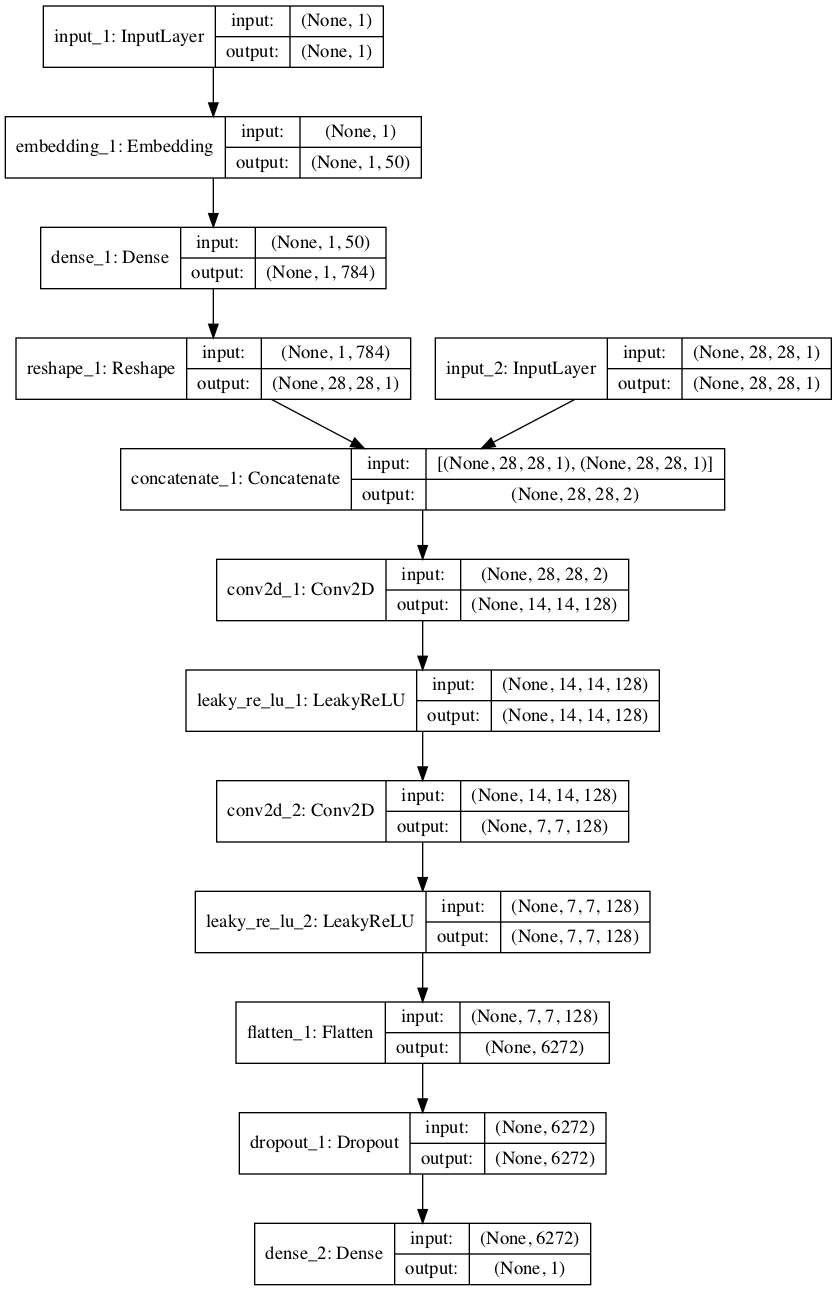

Next, the generator model must be updated to take the class label. This has the effect of making the point in the latent space conditional on the provided class label.

As in the discriminator, the class label is passed through an embedding layer to map it to a unique 50-element vector and is then passed through a fully connected layer with a linear activation before being resized. In this case, the activations of the fully connected layer are resized into a single 7×7 feature map. This is to match the 7×7 feature map activations of the unconditional generator model. The new 7×7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the prior model.

The define_generator() function below implements this, again parameterizing the number of classes as we did with the discriminator model.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=100):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
# 	n_nodes = 7 * 7
	n_nodes = 35 * 35
	li = Dense(n_nodes)(li)
	# reshape to additional channel
# 	li = Reshape((7, 7, 1))(li)
	li = Reshape((35, 35, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
# 	n_nodes = 128 * 7 * 7
	n_nodes = 128 * 35 * 35

	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
# 	gen = Reshape((7, 7, 128))(gen)
	gen = Reshape((35, 35, 128))(gen)

	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
# 	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	out_layer = Conv2D(1, (35, 35), activation='tanh', padding='same')(gen)

	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In this case, you can see the 100-element point in latent space as input and subsequent resizing (left) and the new class label input and embedding layer (right), then the concatenation of the two sets of feature maps (center). The remainder of the model is the same as the unconditional case
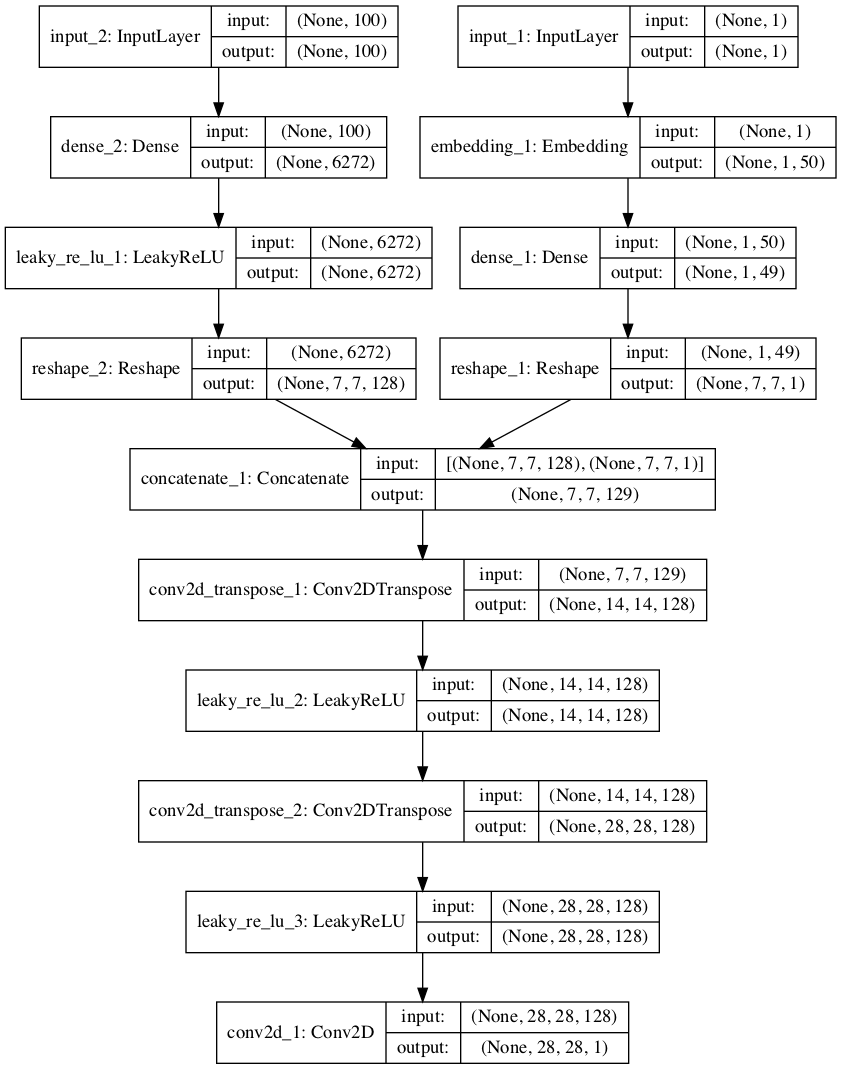

Finally, the composite GAN model requires updating.

The new GAN model will take a point in latent space as input and a class label and generate a prediction of whether input was real or fake, as before.

Using the functional API to design the model, it is important that we explicitly connect the image generated output from the generator as well as the class label input, both as input to the discriminator model. This allows the same class label input to flow down into the generator and down into the discriminator.

The define_gan() function below implements the conditional version of the GAN.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

The plot below summarizes the composite GAN model.

Importantly, it shows the generator model in full with the point in latent space and class label as input, and the connection of the output of the generator and the same class label as input to the discriminator model (last box at the bottom of the plot) and the output of a single class label classification of real or fake.

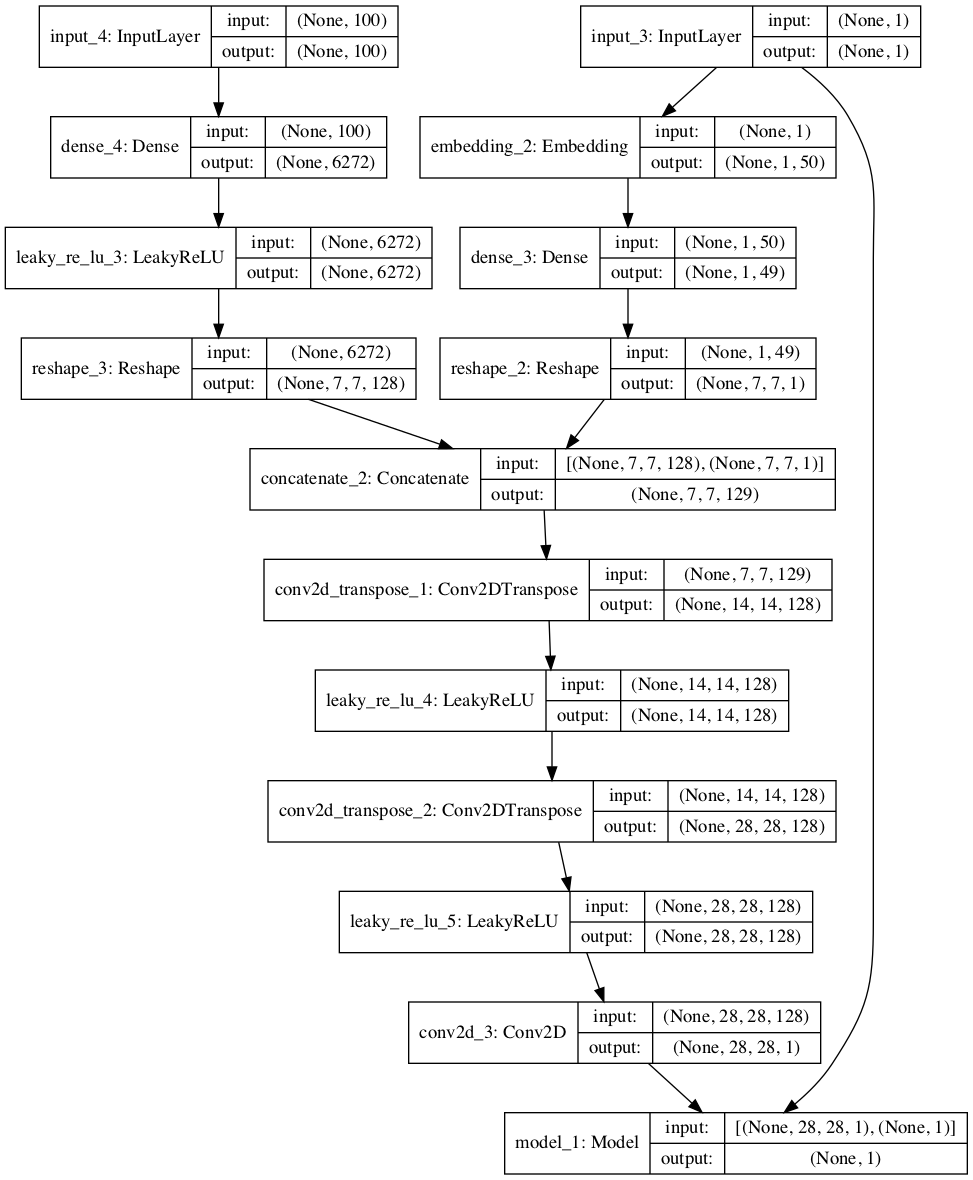

The hard part of the conversion from unconditional to conditional GAN is done, namely the definition and configuration of the model architecture.

Next, all that remains is to update the training process to also use class labels.

First, the load_real_samples() and generate_real_samples() functions for loading the dataset and selecting a batch of samples respectively must be updated to make use of the real class labels from the training dataset. Importantly, the generate_real_samples() function now returns images, clothing labels, and the class label for the discriminator (class=1).

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

Next, the generate_latent_points() function must be updated to also generate an array of randomly selected integer class labels to go along with the randomly selected points in the latent space.

Then the generate_fake_samples() function must be updated to use these randomly generated class labels as input to the generator model when generating new fake images.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

Finally, the train() function must be updated to retrieve and use the class labels in the calls to updating the discriminator and generator models.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [ ]:
with tf.device('/gpu'):
# with strategy.scope():
    # size of the latent space
    latent_dim = 100
    # create the discriminator
    d_model = define_discriminator()
    # create the generator
    g_model = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model)
    # load image data
    dataset = load_real_samples()
    # train model
    train(g_model, d_model, gan_model, dataset, latent_dim)

Running the example may take some time, and GPU hardware is recommended, but not required.

At the end of the run, the model is saved to the file with name ‘cgan_generator.h5‘.

Conditional Clothing Generation
In this section, we will use the trained generator model to conditionally generate new photos of items of clothing.

We can update our code example for generating new images with the model to now generate images conditional on the class label. We can generate 10 examples for each class label in columns.

The complete example is listed below.

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

Extensions
This section lists some ideas for extending the tutorial that you may wish to explore.

Latent Space Size. Experiment by varying the size of the latent space and review the impact on the quality of generated images.
Embedding Size. Experiment by varying the size of the class label embedding, making it smaller or larger, and review the impact on the quality of generated images.
Alternate Architecture. Update the model architecture to concatenate the class label elsewhere in the generator and/or discriminator model, perhaps with different dimensionality, and review the impact on the quality of generated images.